# Desafio data science Semantix (https://archive.ics.uci.edu/ml/datasets/bank+marketing)
Jupyter notebook em Python contendo código pessoal utilizado para resolver o desafio.

In [1]:
# import sys
# reload(sys)
# sys.setdefaultencoding("utf-8")

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Vamos importar o dataset e dar uma olhada no conteúdo

In [47]:
df = pd.read_csv("/home/andre/Documents/BankMarketing/bank-full.csv", sep=";", header=0)

In [4]:
df.shape

(45211, 17)

O dataset tem 45.211 linhas e 17 colunas

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Podemos ver que não há falta de dados. Isto facilita bastante a vida, pois não precisa fazer imput de dados, mas é bom verificar outliers

In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Distribuição da variável de output

In [9]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Notamos que a precisão se a predição for sempre "não" é de 88.3%! O modelo a construir deve obrigatoriamente ter uma predição mais eficaz.

In [10]:
df.groupby("y").mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


In [11]:
df.groupby("job").mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630
blue-collar,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138
entrepreneur,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144
housemaid,46.415323,1392.395161,16.002419,245.825000,2.820968,21.505645,0.371774
management,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006
retired,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693
self-employed,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615
services,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204
student,26.542644,1388.060768,14.897655,246.656716,2.299574,57.041578,0.953092


In [12]:
df.groupby("loan").mean()

,age,balance,day,duration,campaign,pdays,previous
loan,,,,,,,
no,41.008823,1474.453631,15.765085,259.559275,2.750336,41.192983,0.591435
yes,40.555632,774.309912,16.023054,250.845389,2.834622,34.982054,0.522087


In [13]:
df.groupby("housing").mean()

,age,balance,day,duration,campaign,pdays,previous
housing,,,,,,,
no,43.139883,1596.501270,16.066929,256.700911,2.845625,26.288581,0.484787
yes,39.175288,1175.103064,15.598249,259.331476,2.698488,51.312495,0.656665


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

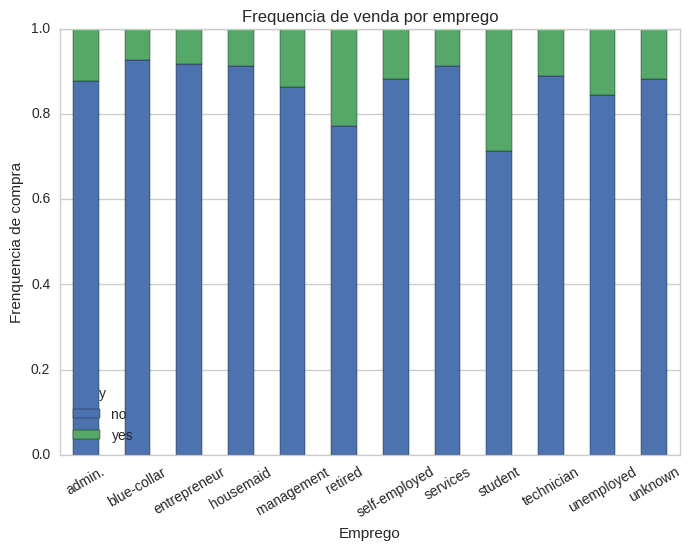

In [14]:
table=pd.crosstab(df.job, df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Frequencia de venda por emprego')
plt.xlabel('Emprego')
plt.ylabel('Frenquencia de compra')
plt.xticks(rotation=30)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

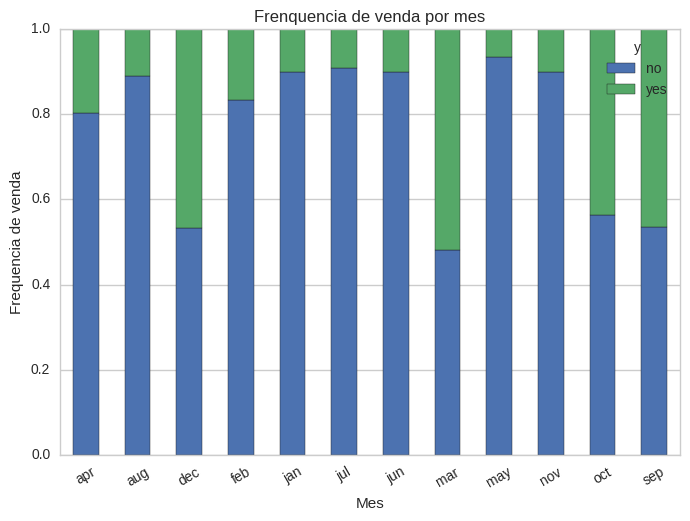

In [15]:
table=pd.crosstab(df.month, df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Frenquencia de venda por mes')
plt.xlabel('Mes')
plt.ylabel('Frequencia de venda')
plt.xticks(rotation=30)

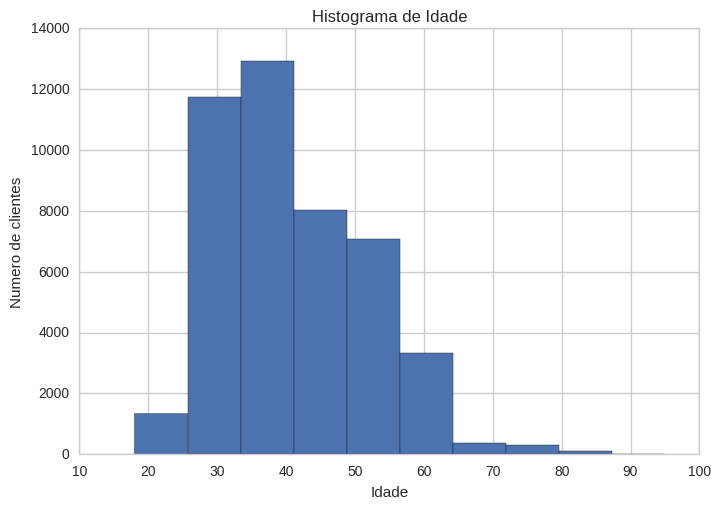

In [16]:
df.age.hist(bins=10)
plt.title('Histograma de Idade')
plt.xlabel('Idade')
plt.ylabel('Numero de clientes')

In [48]:
df.loc[:27728,'year'] = '2008'
df.loc[27729:42591,'year'] = '2009'
df.loc[42592:,'year'] = '2010'
df["date"] = pd.to_datetime(df["day"].map(str) + df["month"] + "2008", format="%d%b%Y")
df['weekday'] = df['date'].dt.weekday_name
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,year,date,weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,2008,2008-05-05,Monday
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,2008,2008-05-05,Monday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,2008,2008-05-05,Monday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,2008,2008-05-05,Monday
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,2008,2008-05-05,Monday


In [18]:
df["y"] = df.y.map({'yes':1, 'no':0})
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,year,date,weekday
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,2008,2008-05-05,Monday
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,2008,2008-05-05,Monday
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,2008,2008-05-05,Monday
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,2008,2008-05-05,Monday
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,2008,2008-05-05,Monday


## Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?

In [19]:
pd.crosstab(df.job, df.loan).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

loan,no,yes
job,,
entrepreneur,0.760592,0.239408
services,0.798748,0.201252
admin.,0.808354,0.191646
blue-collar,0.826963,0.173037
technician,0.827695,0.172305
self-employed,0.854972,0.145028
retired,0.863516,0.136484
management,0.867520,0.132480
housemaid,0.877419,0.122581


In [20]:
pd.crosstab(df.job, df.housing).apply(lambda r: r/r.sum(), axis=1).sort_values("yes", ascending=False)

housing,no,yes
job,,
blue-collar,0.275791,0.724209
services,0.334136,0.665864
admin.,0.384645,0.615355
entrepreneur,0.415602,0.584398
technician,0.458339,0.541661
management,0.505392,0.494608
self-employed,0.515516,0.484484
unemployed,0.583269,0.416731
housemaid,0.679032,0.320968


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


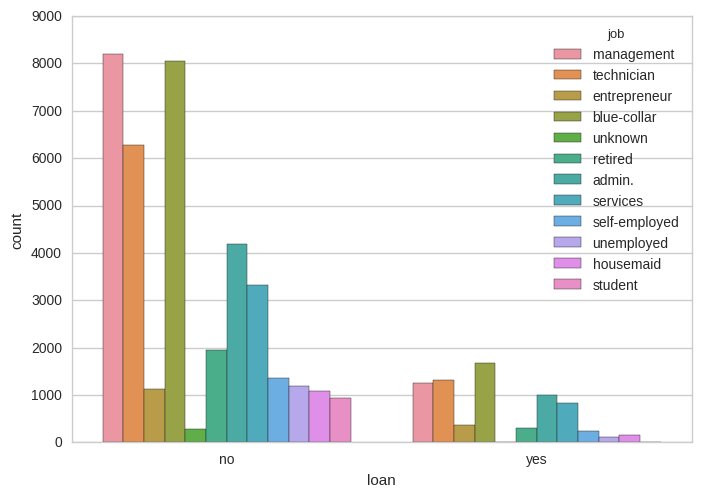

In [21]:
sns.countplot(x="loan", hue="job", data=df)

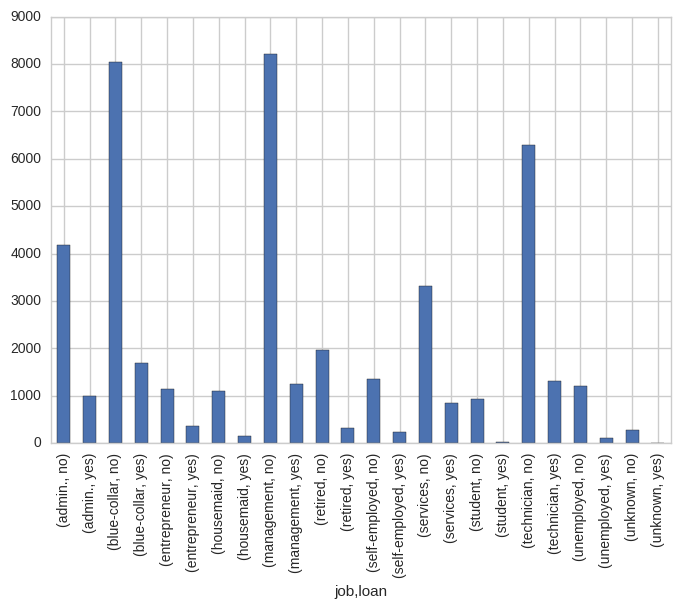

In [22]:
df.groupby("job")["loan"].value_counts().plot(kind="bar")

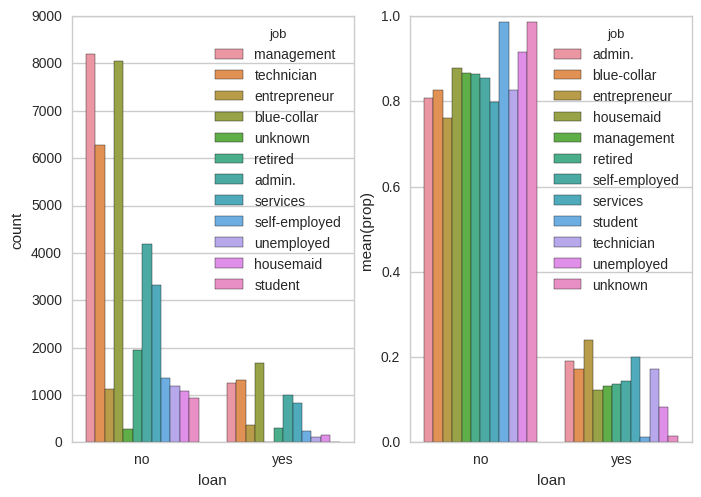

In [23]:
x, y, hue = "loan", "prop", "job"
f, axes = plt.subplots(1, 2)
sns.countplot(x=x, hue=hue, data=df, ax=axes[0])
prop_df = (df[x]\
           .groupby(df[hue])\
           .value_counts(normalize=True)\
           .rename(y)\
           .reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df, ax=axes[1])

## Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

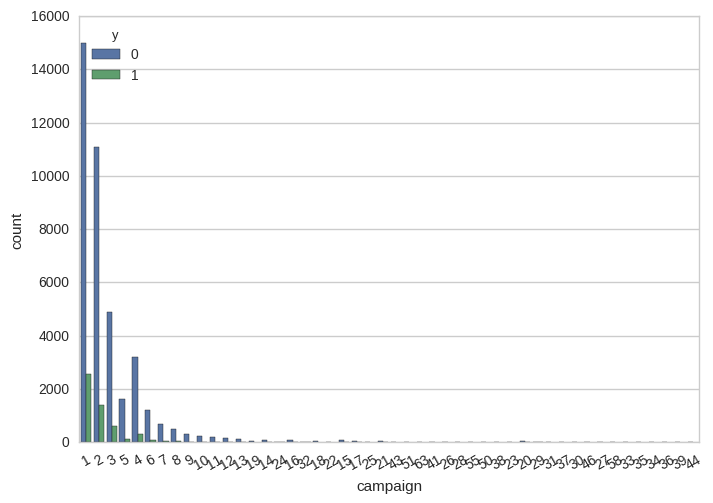

In [24]:
sns.countplot(x="campaign", hue="y", data=df)
plt.xticks(rotation=30)

In [25]:
pd.crosstab(df.campaign, df.y).apply(lambda r: r/r.sum(), axis=1)#.sort_values("yes", ascending=False)

y,0,1
campaign,,
1,0.854024,0.145976
2,0.887965,0.112035
3,0.888064,0.111936
4,0.909994,0.090006
5,0.921202,0.078798
6,0.928737,0.071263
7,0.936054,0.063946
8,0.940741,0.059259
9,0.935780,0.064220


In [26]:
df.groupby("campaign")["y"].count()

campaign
1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
23       22
24       20
25       22
26       13
27       10
28       16
29       16
30        8
31       12
32        9
33        6
34        5
35        4
36        4
37        2
38        3
39        1
41        2
43        3
44        1
46        1
50        2
51        1
55        1
58        1
63        1
Name: y, dtype: int64

In [49]:
# Dummy variables
df.drop(['day','year','date'], axis=1, inplace=True)
categorical = ['job','marital','education','default','housing','loan','contact','weekday','month','poutcome']
for c in categorical:
    cat_list = 'var'+'_'+c
    cat_list = pd.get_dummies(df[c], prefix=c, drop_first=True)
    tmp = df.join(cat_list)
    df = tmp
to_keep = [i for i in df.columns.values.tolist() if i not in categorical]

In [50]:
df_final = df[to_keep]
df_final.columns.values

array(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], dtype=object)

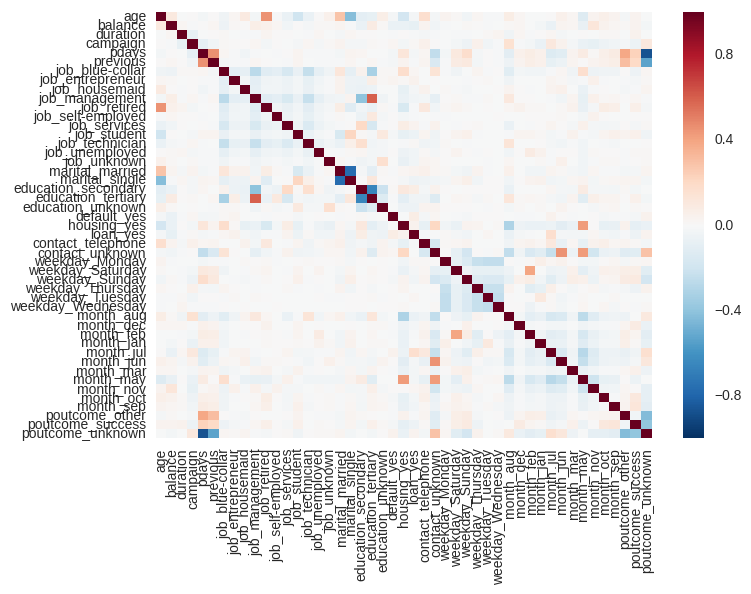

In [51]:
sns.heatmap(df_final.corr())

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = df_final.drop("y", axis=1)
y = df_final.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [53]:
X_train.shape

(36168, 47)

In [54]:
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print confusion_matrix

[[7751  229]
 [ 696  367]]


In [56]:
'Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test))

'Accuracy of logistic regression classifier on test set: 0.90'

In [57]:
from sklearn.metrics import classification_report
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

         no       0.92      0.97      0.94      7980
        yes       0.62      0.35      0.44      1063

avg / total       0.88      0.90      0.88      9043



In [62]:
# import statsmodels.api as sm
# logit = sm.Logit(np.asarray([1 if i=="yes" else 0 for i in y]), X)
# result = logit.fit()
# print result.summary()

## Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

## O resultado da campanha anterior tem relevância na campanha atual?

## Qual o fator determinante para que o banco exija um seguro de crédito?

## Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?